<a href="https://colab.research.google.com/github/MorozovDesu/neural_network_technologies/blob/main/2_%D0%9B%D0%B0%D0%B1%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B2%D1%8B%D0%B5_%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import sys
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import os
import h5py
import PIL
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams["figure.figsize"] = (14,8)

#Создание многослойной сети для работы с датасетом

In [68]:
class Network(object): # используется для описания нейронной сети
    def __init__(self, sizes): # конструктор класса
# self – указатель на объект класса
# sizes – список размеров слоев нейронной сети
        self.num_layers = len(sizes) # задаем количество слоев нейронной сети
        self.sizes = sizes # задаем список размеров слоев нейронной сети
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # задаем случайные начальные смещения
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # задаем случайные начальные веса связей

    def sigmoid(self,z): # определение сигмоидальной функции активации
        return 1.0/(1.0+np.exp(-z))

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a

    def SGD( # Стохастический градиентный спуск
        self # указатель на объект класса
        , training_data # обучающая выборка
        , epochs # количество эпох обучения
        , mini_batch_size # размер подвыборки
        , eta # скорость обучения
        , test_data # тестирующая выборка
        ):
        test_data = list(test_data) # создаем список объектов тестирующей выборки
        n_test = len(test_data) # вычисляем длину тестирующей выборки
        training_data = list(training_data) # создаем список объектов обучающей выборки
        n = len(training_data) # вычисляем размер обучающей выборки
        for j in range(epochs): # цикл по эпохам
            random.shuffle(training_data) # перемешиваем элементы обучающей выборки
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)] # создаем подвыборки
            for mini_batch in mini_batches: # цикл по подвыборкам
              #print(len(mini_batch[0][0]))
              self.update_mini_batch(mini_batch, eta) # один шаг градиентного спуска
            print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test)) # смотрим прогресс в обучении

    def update_mini_batch( # Шаг градиентного спуска
        self # указатель на объект класса
        , mini_batch # подвыборка
        , eta # скорость обучения
        ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y) # послойно вычисляем градиенты dC/db и dC/dw для текущего прецедента (x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # суммируем градиенты dC/db для различных прецедентов текущей подвыборки
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # суммируем градиенты dC/dw для различных прецедентов текущей подвыборки
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)] # обновляем все веса w нейронной сети
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] # обновляем все смещения b нейронной сети

    def backprop( # Алгоритм обратного распространения
        self # указатель на объект класса
      ,x # вектор входных сигналов ,
      ,y # ожидаемый вектор выходных сигналов
      ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        # определение переменных
        activation = x # выходные сигналы слоя (первоначально соответствует выходным сигналам 1-го слоя или входным сигналам сети)
        activations = [x] # список выходных сигналов по всем слоям (первоначально содержит только выходные сигналы 1-го слоя)
        zs = [] # список активационных потенциалов по всем слоям (первоначально пуст)
        # прямое распространение
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b # считаем активационные потенциалы текущего слоя
            zs.append(z) # добавляем элемент (активационные потенциалы слоя) в конец списка
            activation = self.sigmoid(z) # считаем выходные сигналы текущего слоя, применяя сигмоидальную функцию активации к активационным потенциалам слоя
            activations.append(activation) # добавляем элемент (выходные сигналы слоя) в конец списка
  # обратное распространение
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1]) # считаем меру влияния нейронов выходного слоя L на величину ошибки (BP1)
        nabla_b[-1] = delta # градиент dC/db для слоя L (BP3)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # градиент dC/dw для слоя L (BP4)
        for l in range(2, self.num_layers):
          z = zs[-l] # активационные потенциалы l-го слоя (двигаемся по списку справа налево)
          sp = self.sigmoid_prime(z) # считаем сигмоидальную функцию от активационных потенциалов l-го слоя
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # считаем меру влияния нейронов l-го слоя на величину ошибки (BP2)
          nabla_b[-l] = delta # градиент dC/db для l-го слоя (BP3)
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())# градиент dC/dw для l-го слоя (BP4)
        return (nabla_b, nabla_w)

    def evaluate(self, test_data): # Оценка прогресса в обучении
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y): # Вычисление частных производных стоимостной функции по выходным сигналам последнего слоя
      return (output_activations-y)

    def sigmoid_prime(self,z):# Производная сигмоидальной функции
      return self.sigmoid(z)*(1-self.sigmoid(z))


In [69]:
input_folder = 'drive/MyDrive/archive/all_letters_image/all_letters_image/'
all_letters_filename = os.listdir(input_folder)
len(all_letters_filename)

14190

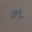

In [70]:
#Это одно из наших изображений. Размер каждого изображения составляет 32 на 32 пикселя.
#Затем мы преобразуем каждое изображение в 3d-массив numpy.
i = Image.open("drive/MyDrive/archive/all_letters_image/all_letters_image/20_102.png")
i

In [71]:
i_arr = np.array(i)
# i_arr
# Все 32 матрицы внутри этого массива представляют собой одно изображение.
# Каждая матрица представляет собой 1 строку этого изображения.
# Длина одной строки изображения составляет 32 пикселя, поэтому каждая матрица имеет 32 строки.
# Каждая строка матрицы имеет 4 столбца и представляет собой 1 пиксель. Для этого пикселя каждый столбец представляет собой значения цвета - насколько он красный, зеленый и синий - плюс непрозрачность цветов (последний столбец).
# Поэтому каждая матрица имеет размер 32 на 4. Общее количество пикселей в одном изображении составляет 32 * 32 = 1024.

# Каждое значение цвета находится в диапазоне [0:255].
# Это означает, что для каждого цвета существует 256 оттенков. В сумме все комбинации этих цветов дают нам 256ˆ3 = 16 777 216 возможных цветов.



In [72]:
from keras.preprocessing import image
import numpy as np

# Функция для преобразования изображения в тензор
# Параметры:
# - img_name: Имя файла изображения
# - input_folder: Путь к папке, где находится изображение
# Возвращает:
# - Тензорное представление изображения
def img_to_array(img_name, input_folder):
    # Загрузка изображения из указанной папки и изменение его размера до 32x32 пикселей
    img = image.load_img(input_folder + img_name, target_size=(32, 32))

    # Преобразование изображения в массив NumPy
    x = image.img_to_array(img)

    # Расширение размерности массива для подготовки его к обработке нейронной сетью
    return np.expand_dims(x, axis=0)

# Функция для преобразования списка имен изображений в тензор
# Параметры:
# - img_names: Список имен файлов изображений
# - input_folder: Путь к папке, где находятся изображения
# Возвращает:
# - Массив NumPy, содержащий тензоры всех изображений из списка
def data_to_tensor(img_names, input_folder):
    # Создание списка тензоров путем применения функции img_to_array к каждому имени изображения
    list_of_tensors = [img_to_array(img_name, input_folder) for img_name in img_names]

    # Стекирование отдельных тензоров вертикально для создания одного массива NumPy
    return np.vstack(list_of_tensors)


In [73]:
# Загрузка данных из CSV-файла в переменную "data"
data = pd.read_csv("drive/MyDrive/archive/all_letters_info.csv")
# Извлечение имен файлов изображений из столбца "file"
image_names = data['file']
letters = data[ 'letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(image_names, input_folder)
# tensors[0]


In [74]:
# Вывод размера (формы) массива тензоров
print('Форма тензоров:', tensors.shape)
# Вывод размера (формы) массива меток (целевых значений)
print('Форма меток (целевых значений):', targets.shape)

Форма тензоров: (14190, 32, 32, 3)
Форма меток (целевых значений): (14190,)


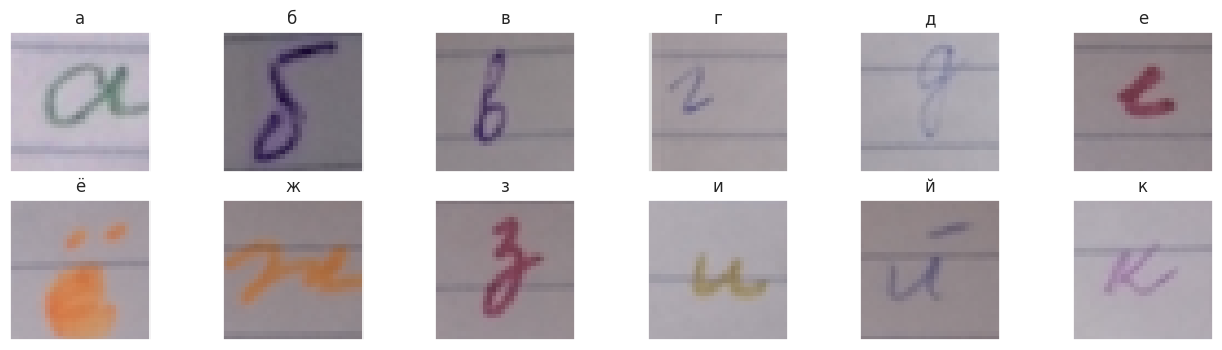

In [75]:
# Функция для отображения изображений из файлов с использованием OpenCV
# Параметры:
# - img_path: Путь к файлу изображения
# - ax: Объект для отображения изображения (область на графике)
def display_images(img_path, ax):
    # Загрузка изображения из указанного пути
    img = cv2.imread(input_folder + img_path)

    # Отображение изображения, преобразовав его из формата BGR в RGB
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Создание графического окна с определенными размерами
fig = plt.figure(figsize=(16, 4))

# Цикл для отображения 12 изображений
for i in range(12):
    # Создание области для каждого изображения внутри графического окна
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i * 50])

    # Вызов функции для отображения изображения с указанным именем файла и заданной областью (ax)
    display_images(image_names[i * 50], ax)

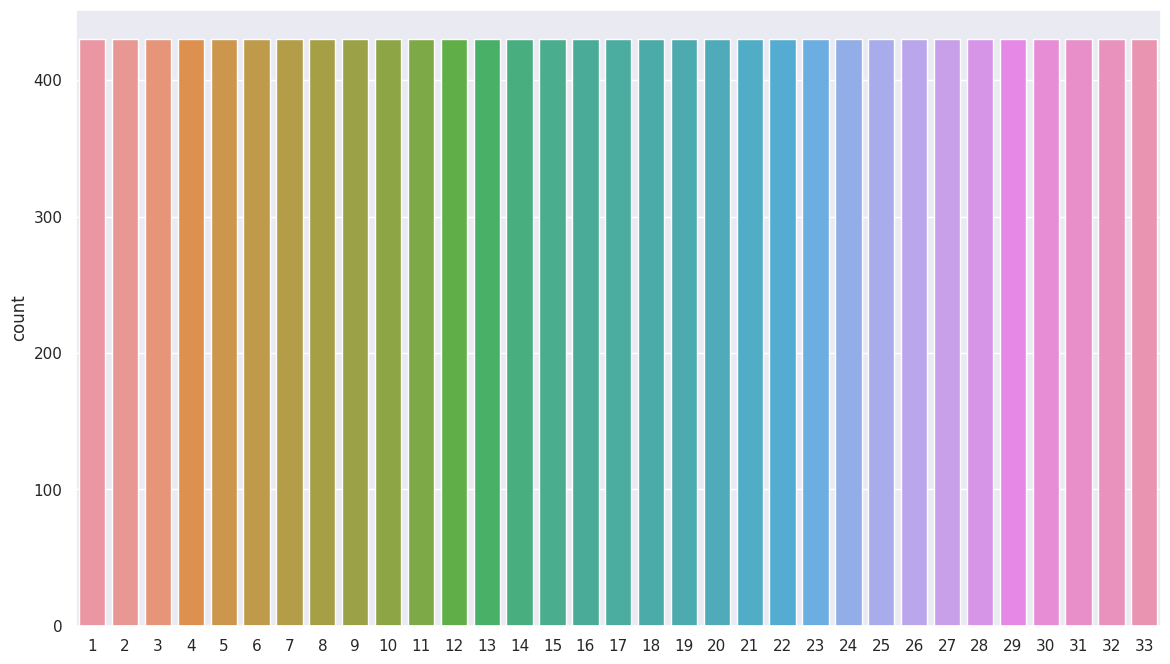

In [76]:
# Создание графика countplot
sns.set(style="darkgrid")
ax = sns.countplot(x=targets)

# Отображение графика
plt.show()

In [77]:
# Классы идеально сбалансированы, что очень важно для классификационной модели.
# Если классы несбалансированы, то модель будет пытаться максимизировать точность
# для большинства классов, оставляя без внимания другие классы, что приведет к менее точным прогнозам для меньшинств.

In [78]:
# Нормализация
# Для уменьшения влияния перепадов освещенности мы проводим нормализацию.
X = tensors.astype("float32")/255
# Кроме того, CNN быстрее сходится на данных [0...1], чем на [0...255]. Преобразуем входные данные к типу float, а затем разделим на 255 (максимальная яркость для каждого цвета).

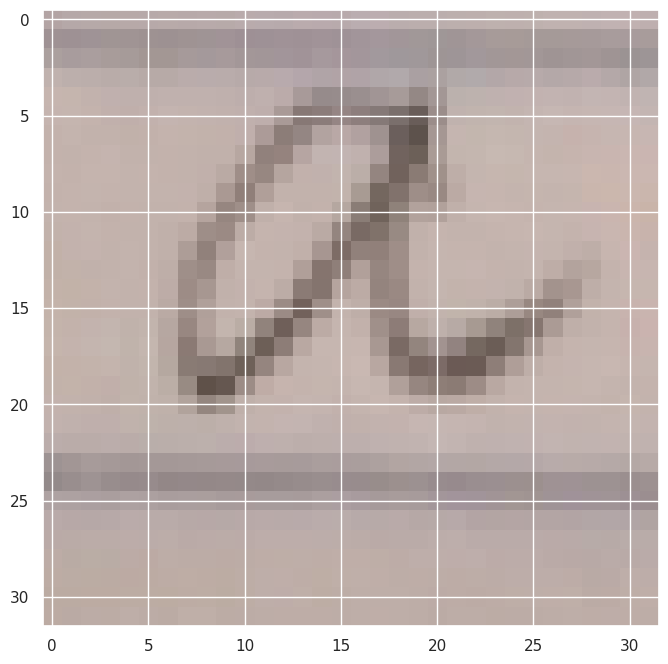

In [79]:
arr = X[2]
arr_ = np.squeeze(arr)
plt.imshow(arr_)
plt.show()

In [80]:
targets[0]

1

In [81]:
y = targets

img_rows, img_cols = 32, 32 # потому что наши картинки имеют размер 32 на 32 пикселя
num_classes = 33 # потому что в русинском алфавите 33 буквы

y = keras.utils.to_categorical(y-1, num_classes) # targets-1, потому что наш список начинается с 1, а не с 0, как ожидает keras

In [82]:
print(X.shape)
print(y.shape)

(14190, 32, 32, 3)
(14190, 33)


In [83]:
def captch_ex(file_name):
    img = cv2.imread(file_name)
    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # for black text , cv.THRESH_BINARY_INV

    '''
            line  8 to 12  : Remove noisy portion
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # dilate , more the iteration more the dilation

    # for cv2.x.x

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # findContours returns 3 variables for getting contours

    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.png'
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # write original image with added contours to disk
    cv2.imshow('captcha_result', img)
    cv2.waitKey()

In [84]:
file_name = 'drive/MyDrive/archive/all_letters_image/all_letters_image/04_100.png'
# captch_ex(file_name)

In [85]:
# Grayscaled tensors
X_grey = np.dot(X[...,:3], [0.299, 0.587, 0.114])
# X_grey = tf.expand_dims(X_grey, axis=3)
print ('Grayscaled Tensor shape:', X_grey.shape)

Grayscaled Tensor shape: (14190, 32, 32)


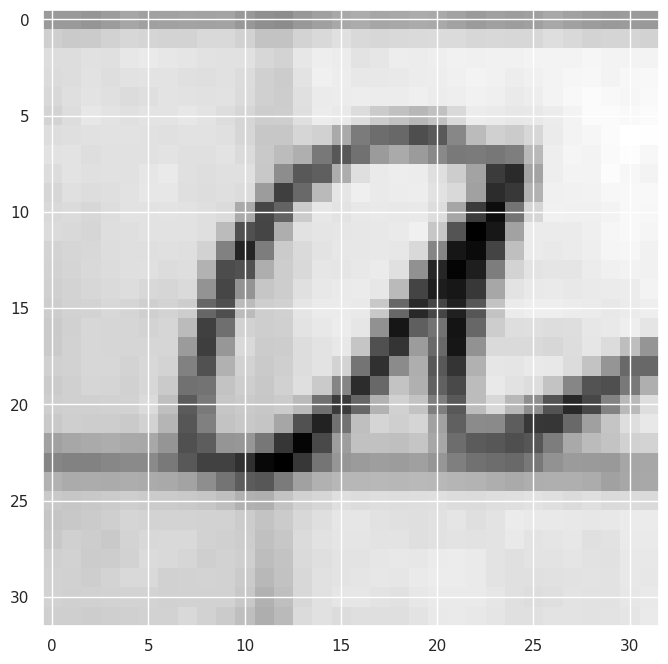

In [86]:
plt.imshow(X_grey[3], cmap=plt.get_cmap("gray"))

In [87]:
# Split the data into train, validation and test sets.

X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.1, random_state=1)

In [88]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample/image mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# grey_X_train = tf.expand_dims(X_train, axis=3)
# grey_X_val = tf.expand_dims(X_val, axis=3)
# grey_X_test = tf.expand_dims(X_test, axis=3)

datagen.fit(X_train)

In [89]:
# Define the model architecture

deep_RU_model = Sequential()

deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (img_rows,img_cols,3)))
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Flatten())
deep_RU_model.add(Dense(256, activation = "relu"))
deep_RU_model.add(Dropout(0.5))
deep_RU_model.add(Dense(33, activation = "softmax"))

In [90]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [91]:
# Compile the model:
deep_RU_model.compile(loss="categorical_crossentropy", optimizer = optimizer,metrics=["accuracy"])

In [92]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [93]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [94]:
history = deep_RU_model.fit(datagen.flow(X_train,y_train, batch_size=90), validation_data = (X_val, y_val),
                            epochs=139, callbacks=[learning_rate_reduction, es, mc])# сделать epochs=139

Epoch 1/139
128/128 [==============================] - ETA: 0s - loss: 3.5032 - accuracy: 0.0305


Epoch 1: val_accuracy improved from -inf to 0.02660, saving model to best_model.h5
128/128 [==============================] - 98s 759ms/step - loss: 3.5032 - accuracy: 0.0305 - val_loss: 3.4953 - val_accuracy: 0.0266 - lr: 0.0010
Epoch 2/139


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - ETA: 0s - loss: 3.4706 - accuracy: 0.0399


Epoch 2: val_accuracy improved from 0.02660 to 0.03912, saving model to best_model.h5
128/128 [==============================] - 95s 744ms/step - loss: 3.4706 - accuracy: 0.0399 - val_loss: 3.4443 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 3/139
128/128 [==============================] - ETA: 0s - loss: 3.4137 - accuracy: 0.0512


Epoch 3: val_accuracy improved from 0.03912 to 0.06495, saving model to best_model.h5
128/128 [==============================] - 112s 875ms/step - loss: 3.4137 - accuracy: 0.0512 - val_loss: 3.3648 - val_accuracy: 0.0649 - lr: 0.0010
Epoch 4/139
128/128 [==============================] - ETA: 0s - loss: 3.3902 - accuracy: 0.0593


Epoch 4: val_accuracy improved from 0.06495 to 0.07433, saving model to best_model.h5
128/128 [==============================] - 96s 751ms/step - loss: 3.3902 - accuracy: 0.0593 - val_loss: 3.3317 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 5/139
128/128 [==============================] - ETA: 0s - loss: 3.3500 - accuracy: 0.0638


Epoch 5: val_accuracy did not improve from 0.07433
128/128 [==============================] - 99s 771ms/step - loss: 3.3500 - accuracy: 0.0638 - val_loss: 3.4536 - val_accuracy: 0.0516 - lr: 0.0010
Epoch 6/139
128/128 [==============================] - ETA: 0s - loss: 3.3090 - accuracy: 0.0742


Epoch 6: val_accuracy improved from 0.07433 to 0.10563, saving model to best_model.h5
128/128 [==============================] - 97s 760ms/step - loss: 3.3090 - accuracy: 0.0742 - val_loss: 3.1873 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 7/139
128/128 [==============================] - ETA: 0s - loss: 3.2505 - accuracy: 0.0852


Epoch 7: val_accuracy improved from 0.10563 to 0.16432, saving model to best_model.h5
128/128 [==============================] - 97s 758ms/step - loss: 3.2505 - accuracy: 0.0852 - val_loss: 2.9972 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 8/139
128/128 [==============================] - ETA: 0s - loss: 3.1002 - accuracy: 0.1293


Epoch 8: val_accuracy improved from 0.16432 to 0.28873, saving model to best_model.h5
128/128 [==============================] - 95s 742ms/step - loss: 3.1002 - accuracy: 0.1293 - val_loss: 2.6316 - val_accuracy: 0.2887 - lr: 0.0010
Epoch 9/139
128/128 [==============================] - ETA: 0s - loss: 2.8906 - accuracy: 0.1793


Epoch 9: val_accuracy did not improve from 0.28873
128/128 [==============================] - 98s 766ms/step - loss: 2.8906 - accuracy: 0.1793 - val_loss: 2.6690 - val_accuracy: 0.2457 - lr: 0.0010
Epoch 10/139
128/128 [==============================] - ETA: 0s - loss: 2.6627 - accuracy: 0.2376


Epoch 10: val_accuracy improved from 0.28873 to 0.45931, saving model to best_model.h5
128/128 [==============================] - 96s 745ms/step - loss: 2.6627 - accuracy: 0.2376 - val_loss: 2.0287 - val_accuracy: 0.4593 - lr: 0.0010
Epoch 11/139
128/128 [==============================] - ETA: 0s - loss: 2.4899 - accuracy: 0.2867


Epoch 11: val_accuracy improved from 0.45931 to 0.49374, saving model to best_model.h5
128/128 [==============================] - 94s 738ms/step - loss: 2.4899 - accuracy: 0.2867 - val_loss: 1.8421 - val_accuracy: 0.4937 - lr: 0.0010
Epoch 12/139
128/128 [==============================] - ETA: 0s - loss: 2.2951 - accuracy: 0.3369


Epoch 12: val_accuracy improved from 0.49374 to 0.58685, saving model to best_model.h5
128/128 [==============================] - 98s 762ms/step - loss: 2.2951 - accuracy: 0.3369 - val_loss: 1.5421 - val_accuracy: 0.5869 - lr: 0.0010
Epoch 13/139
128/128 [==============================] - ETA: 0s - loss: 2.1135 - accuracy: 0.3887


Epoch 13: val_accuracy improved from 0.58685 to 0.65258, saving model to best_model.h5
128/128 [==============================] - 94s 738ms/step - loss: 2.1135 - accuracy: 0.3887 - val_loss: 1.3961 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 14/139
128/128 [==============================] - ETA: 0s - loss: 1.9394 - accuracy: 0.4341


Epoch 14: val_accuracy improved from 0.65258 to 0.65571, saving model to best_model.h5
128/128 [==============================] - 99s 772ms/step - loss: 1.9394 - accuracy: 0.4341 - val_loss: 1.2670 - val_accuracy: 0.6557 - lr: 0.0010
Epoch 15/139
128/128 [==============================] - ETA: 0s - loss: 1.8121 - accuracy: 0.4728


Epoch 15: val_accuracy improved from 0.65571 to 0.66432, saving model to best_model.h5
128/128 [==============================] - 95s 744ms/step - loss: 1.8121 - accuracy: 0.4728 - val_loss: 1.1992 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 16/139
128/128 [==============================] - ETA: 0s - loss: 1.6368 - accuracy: 0.5227


Epoch 16: val_accuracy improved from 0.66432 to 0.69171, saving model to best_model.h5
128/128 [==============================] - 97s 756ms/step - loss: 1.6368 - accuracy: 0.5227 - val_loss: 1.1381 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 17/139
128/128 [==============================] - ETA: 0s - loss: 1.5207 - accuracy: 0.5522


Epoch 17: val_accuracy improved from 0.69171 to 0.76839, saving model to best_model.h5
128/128 [==============================] - 100s 785ms/step - loss: 1.5207 - accuracy: 0.5522 - val_loss: 0.8382 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 18/139
128/128 [==============================] - ETA: 0s - loss: 1.4003 - accuracy: 0.5947


Epoch 18: val_accuracy improved from 0.76839 to 0.79969, saving model to best_model.h5
128/128 [==============================] - 95s 742ms/step - loss: 1.4003 - accuracy: 0.5947 - val_loss: 0.7419 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 19/139
128/128 [==============================] - ETA: 0s - loss: 1.3328 - accuracy: 0.6114


Epoch 19: val_accuracy improved from 0.79969 to 0.82551, saving model to best_model.h5
128/128 [==============================] - 97s 761ms/step - loss: 1.3328 - accuracy: 0.6114 - val_loss: 0.6103 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 20/139
128/128 [==============================] - ETA: 0s - loss: 1.2488 - accuracy: 0.6300


Epoch 20: val_accuracy did not improve from 0.82551
128/128 [==============================] - 96s 746ms/step - loss: 1.2488 - accuracy: 0.6300 - val_loss: 0.6325 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 21/139
128/128 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.6523


Epoch 21: val_accuracy improved from 0.82551 to 0.84351, saving model to best_model.h5
128/128 [==============================] - 98s 762ms/step - loss: 1.1869 - accuracy: 0.6523 - val_loss: 0.5242 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 22/139
128/128 [==============================] - ETA: 0s - loss: 1.1368 - accuracy: 0.6650


Epoch 22: val_accuracy did not improve from 0.84351
128/128 [==============================] - 94s 736ms/step - loss: 1.1368 - accuracy: 0.6650 - val_loss: 0.6294 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 23/139
128/128 [==============================] - ETA: 0s - loss: 1.0839 - accuracy: 0.6762


Epoch 23: val_accuracy improved from 0.84351 to 0.86854, saving model to best_model.h5
128/128 [==============================] - 99s 770ms/step - loss: 1.0839 - accuracy: 0.6762 - val_loss: 0.4531 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 24/139
128/128 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.6941


Epoch 24: val_accuracy improved from 0.86854 to 0.86933, saving model to best_model.h5
128/128 [==============================] - 97s 754ms/step - loss: 1.0233 - accuracy: 0.6941 - val_loss: 0.4240 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 25/139
128/128 [==============================] - ETA: 0s - loss: 0.9797 - accuracy: 0.7101


Epoch 25: val_accuracy improved from 0.86933 to 0.87793, saving model to best_model.h5
128/128 [==============================] - 95s 743ms/step - loss: 0.9797 - accuracy: 0.7101 - val_loss: 0.4126 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 26/139
128/128 [==============================] - ETA: 0s - loss: 0.9378 - accuracy: 0.7227


Epoch 26: val_accuracy did not improve from 0.87793
128/128 [==============================] - 97s 758ms/step - loss: 0.9378 - accuracy: 0.7227 - val_loss: 0.4248 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 27/139
128/128 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.7246


Epoch 27: val_accuracy improved from 0.87793 to 0.88263, saving model to best_model.h5
128/128 [==============================] - 95s 739ms/step - loss: 0.9221 - accuracy: 0.7246 - val_loss: 0.3832 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 28/139
128/128 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.7404


Epoch 28: val_accuracy did not improve from 0.88263
128/128 [==============================] - 101s 789ms/step - loss: 0.8689 - accuracy: 0.7404 - val_loss: 0.5185 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 29/139
128/128 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.7423


Epoch 29: val_accuracy improved from 0.88263 to 0.89593, saving model to best_model.h5
128/128 [==============================] - 95s 740ms/step - loss: 0.8484 - accuracy: 0.7423 - val_loss: 0.3907 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 30/139
128/128 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.7600


Epoch 30: val_accuracy improved from 0.89593 to 0.89906, saving model to best_model.h5
128/128 [==============================] - 96s 747ms/step - loss: 0.8045 - accuracy: 0.7600 - val_loss: 0.3395 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 31/139
128/128 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.7657


Epoch 31: val_accuracy did not improve from 0.89906
128/128 [==============================] - 95s 741ms/step - loss: 0.7882 - accuracy: 0.7657 - val_loss: 0.3508 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 32/139
128/128 [==============================] - ETA: 0s - loss: 0.7670 - accuracy: 0.7718


Epoch 32: val_accuracy improved from 0.89906 to 0.90063, saving model to best_model.h5
128/128 [==============================] - 98s 761ms/step - loss: 0.7670 - accuracy: 0.7718 - val_loss: 0.3336 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 33/139
128/128 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.7693


Epoch 33: val_accuracy did not improve from 0.90063
128/128 [==============================] - 97s 759ms/step - loss: 0.7674 - accuracy: 0.7693 - val_loss: 0.3336 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 34/139
128/128 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.7800


Epoch 34: val_accuracy did not improve from 0.90063
128/128 [==============================] - 97s 759ms/step - loss: 0.7360 - accuracy: 0.7800 - val_loss: 0.3348 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 35/139
128/128 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7836


Epoch 35: val_accuracy did not improve from 0.90063
128/128 [==============================] - 95s 739ms/step - loss: 0.7230 - accuracy: 0.7836 - val_loss: 0.3362 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 36/139
128/128 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7922


Epoch 36: val_accuracy did not improve from 0.90063
128/128 [==============================] - 97s 759ms/step - loss: 0.6962 - accuracy: 0.7922 - val_loss: 0.4131 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 37/139
128/128 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.7956


Epoch 37: val_accuracy improved from 0.90063 to 0.90376, saving model to best_model.h5
128/128 [==============================] - 97s 759ms/step - loss: 0.6939 - accuracy: 0.7956 - val_loss: 0.3106 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 38/139
128/128 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.7914


Epoch 38: val_accuracy improved from 0.90376 to 0.91236, saving model to best_model.h5
128/128 [==============================] - 97s 751ms/step - loss: 0.6996 - accuracy: 0.7914 - val_loss: 0.3086 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 39/139
128/128 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.7974


Epoch 39: val_accuracy improved from 0.91236 to 0.92332, saving model to best_model.h5
128/128 [==============================] - 99s 770ms/step - loss: 0.6823 - accuracy: 0.7974 - val_loss: 0.2541 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 40/139
128/128 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.8053


Epoch 40: val_accuracy did not improve from 0.92332
128/128 [==============================] - 95s 740ms/step - loss: 0.6596 - accuracy: 0.8053 - val_loss: 0.2784 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 41/139
128/128 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.8056


Epoch 41: val_accuracy improved from 0.92332 to 0.92410, saving model to best_model.h5
128/128 [==============================] - 97s 759ms/step - loss: 0.6373 - accuracy: 0.8056 - val_loss: 0.2659 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 42/139
128/128 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.8140


Epoch 42: val_accuracy improved from 0.92410 to 0.92567, saving model to best_model.h5
128/128 [==============================] - 95s 740ms/step - loss: 0.6348 - accuracy: 0.8140 - val_loss: 0.2558 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 43/139
128/128 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.8129


Epoch 43: val_accuracy did not improve from 0.92567
128/128 [==============================] - 97s 760ms/step - loss: 0.6203 - accuracy: 0.8129 - val_loss: 0.3206 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 44/139
128/128 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.8139


Epoch 44: val_accuracy improved from 0.92567 to 0.93192, saving model to best_model.h5
128/128 [==============================] - 95s 741ms/step - loss: 0.6257 - accuracy: 0.8139 - val_loss: 0.2344 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 45/139
128/128 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.8205


Epoch 45: val_accuracy did not improve from 0.93192
128/128 [==============================] - 99s 772ms/step - loss: 0.5995 - accuracy: 0.8205 - val_loss: 0.2341 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 46/139
128/128 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.8249


Epoch 46: val_accuracy did not improve from 0.93192
128/128 [==============================] - 95s 742ms/step - loss: 0.6021 - accuracy: 0.8249 - val_loss: 0.3421 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 47/139
128/128 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.8259


Epoch 47: val_accuracy did not improve from 0.93192
128/128 [==============================] - 98s 764ms/step - loss: 0.5930 - accuracy: 0.8259 - val_loss: 0.2651 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 48/139
128/128 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.8239


Epoch 48: val_accuracy improved from 0.93192 to 0.94210, saving model to best_model.h5
128/128 [==============================] - 97s 760ms/step - loss: 0.5850 - accuracy: 0.8239 - val_loss: 0.2181 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 49/139
128/128 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.8317


Epoch 49: val_accuracy did not improve from 0.94210
128/128 [==============================] - 95s 740ms/step - loss: 0.5907 - accuracy: 0.8317 - val_loss: 0.2803 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 50/139
128/128 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.8269


Epoch 50: val_accuracy did not improve from 0.94210
128/128 [==============================] - 100s 779ms/step - loss: 0.5826 - accuracy: 0.8269 - val_loss: 0.2232 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 51/139
128/128 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.8281


Epoch 51: val_accuracy did not improve from 0.94210
128/128 [==============================] - 95s 741ms/step - loss: 0.5872 - accuracy: 0.8281 - val_loss: 0.2411 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 52/139
128/128 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.8333


Epoch 52: val_accuracy did not improve from 0.94210
128/128 [==============================] - 95s 739ms/step - loss: 0.5697 - accuracy: 0.8333 - val_loss: 0.2329 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 53/139
128/128 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.8322


Epoch 53: val_accuracy did not improve from 0.94210
128/128 [==============================] - 96s 748ms/step - loss: 0.5647 - accuracy: 0.8322 - val_loss: 0.2457 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 54/139
128/128 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.8273


Epoch 54: val_accuracy did not improve from 0.94210
128/128 [==============================] - 99s 770ms/step - loss: 0.5792 - accuracy: 0.8273 - val_loss: 0.2269 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 55/139
128/128 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.8395


Epoch 55: val_accuracy did not improve from 0.94210
128/128 [==============================] - 97s 759ms/step - loss: 0.5620 - accuracy: 0.8395 - val_loss: 0.2557 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 56/139
128/128 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.8367


Epoch 56: val_accuracy did not improve from 0.94210
128/128 [==============================] - 97s 757ms/step - loss: 0.5606 - accuracy: 0.8367 - val_loss: 0.2269 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 57/139
128/128 [==============================] - ETA: 0s - loss: 0.5648 - accuracy: 0.8358


Epoch 57: val_accuracy did not improve from 0.94210
128/128 [==============================] - 96s 753ms/step - loss: 0.5648 - accuracy: 0.8358 - val_loss: 0.2073 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 58/139
128/128 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.8390


Epoch 58: val_accuracy did not improve from 0.94210
128/128 [==============================] - 96s 754ms/step - loss: 0.5564 - accuracy: 0.8390 - val_loss: 0.2276 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 59/139
128/128 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.8390


Epoch 59: val_accuracy did not improve from 0.94210
128/128 [==============================] - 99s 769ms/step - loss: 0.5438 - accuracy: 0.8390 - val_loss: 0.2310 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 60/139
128/128 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.8416


Epoch 60: val_accuracy did not improve from 0.94210
128/128 [==============================] - 95s 736ms/step - loss: 0.5425 - accuracy: 0.8416 - val_loss: 0.2197 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 61/139
128/128 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8411


Epoch 61: val_accuracy did not improve from 0.94210
128/128 [==============================] - 101s 791ms/step - loss: 0.5405 - accuracy: 0.8411 - val_loss: 0.2086 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 62/139
128/128 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8443


Epoch 62: val_accuracy did not improve from 0.94210
128/128 [==============================] - 95s 741ms/step - loss: 0.5300 - accuracy: 0.8443 - val_loss: 0.2154 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 63/139
128/128 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.8453


Epoch 63: val_accuracy did not improve from 0.94210
128/128 [==============================] - 97s 754ms/step - loss: 0.5329 - accuracy: 0.8453 - val_loss: 0.2024 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 64/139
128/128 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.8474


Epoch 64: val_accuracy did not improve from 0.94210
128/128 [==============================] - 98s 766ms/step - loss: 0.5379 - accuracy: 0.8474 - val_loss: 0.2072 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 65/139
128/128 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.8476


Epoch 65: val_accuracy did not improve from 0.94210
128/128 [==============================] - 97s 755ms/step - loss: 0.5259 - accuracy: 0.8476 - val_loss: 0.2258 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 66/139
128/128 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8485


Epoch 66: val_accuracy did not improve from 0.94210
128/128 [==============================] - 97s 759ms/step - loss: 0.5394 - accuracy: 0.8485 - val_loss: 0.2223 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 67/139
128/128 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.8517


Epoch 67: val_accuracy improved from 0.94210 to 0.94757, saving model to best_model.h5
128/128 [==============================] - 98s 770ms/step - loss: 0.5177 - accuracy: 0.8517 - val_loss: 0.2091 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 68/139
128/128 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.8480


Epoch 68: val_accuracy did not improve from 0.94757
128/128 [==============================] - 94s 738ms/step - loss: 0.5321 - accuracy: 0.8480 - val_loss: 0.1974 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 69/139
128/128 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.8501


Epoch 69: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 742ms/step - loss: 0.5244 - accuracy: 0.8501 - val_loss: 0.2447 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 70/139
128/128 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.8489


Epoch 70: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 746ms/step - loss: 0.5330 - accuracy: 0.8489 - val_loss: 0.1947 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 71/139
128/128 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8531


Epoch 71: val_accuracy did not improve from 0.94757
128/128 [==============================] - 98s 762ms/step - loss: 0.5294 - accuracy: 0.8531 - val_loss: 0.3032 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 72/139
128/128 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.8539


Epoch 72: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 739ms/step - loss: 0.5178 - accuracy: 0.8539 - val_loss: 0.2065 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 73/139
128/128 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8503


Epoch 73: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 749ms/step - loss: 0.5175 - accuracy: 0.8503 - val_loss: 0.2914 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 74/139
128/128 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.8496


Epoch 74: val_accuracy did not improve from 0.94757
128/128 [==============================] - 99s 772ms/step - loss: 0.5307 - accuracy: 0.8496 - val_loss: 0.2070 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 75/139
128/128 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.8502


Epoch 75: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 739ms/step - loss: 0.5317 - accuracy: 0.8502 - val_loss: 0.2344 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 76/139
128/128 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8517


Epoch 76: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 739ms/step - loss: 0.5260 - accuracy: 0.8517 - val_loss: 0.2883 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 77/139
128/128 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8535


Epoch 77: val_accuracy did not improve from 0.94757
128/128 [==============================] - 102s 798ms/step - loss: 0.5120 - accuracy: 0.8535 - val_loss: 0.1803 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 78/139
128/128 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.8603


Epoch 78: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 758ms/step - loss: 0.4961 - accuracy: 0.8603 - val_loss: 0.1918 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 79/139
128/128 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.8587


Epoch 79: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 741ms/step - loss: 0.5040 - accuracy: 0.8587 - val_loss: 0.2152 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 80/139
128/128 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.8540


Epoch 80: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 762ms/step - loss: 0.5309 - accuracy: 0.8540 - val_loss: 0.1995 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 81/139
128/128 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.8616


Epoch 81: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 745ms/step - loss: 0.5077 - accuracy: 0.8616 - val_loss: 0.2143 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 82/139
128/128 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.8633


Epoch 82: val_accuracy did not improve from 0.94757
128/128 [==============================] - 94s 735ms/step - loss: 0.4964 - accuracy: 0.8633 - val_loss: 0.2357 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 83/139
128/128 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.8584


Epoch 83: val_accuracy did not improve from 0.94757
128/128 [==============================] - 99s 771ms/step - loss: 0.5185 - accuracy: 0.8584 - val_loss: 0.2690 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 84/139
128/128 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.8585


Epoch 84: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 741ms/step - loss: 0.5144 - accuracy: 0.8585 - val_loss: 0.2240 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 85/139
128/128 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.8570


Epoch 85: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 747ms/step - loss: 0.5107 - accuracy: 0.8570 - val_loss: 0.2324 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 86/139
128/128 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.8584


Epoch 86: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 740ms/step - loss: 0.5105 - accuracy: 0.8584 - val_loss: 0.2163 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 87/139
128/128 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.8586


Epoch 87: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 752ms/step - loss: 0.5084 - accuracy: 0.8586 - val_loss: 0.1803 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 88/139
128/128 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.8556


Epoch 88: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 758ms/step - loss: 0.5191 - accuracy: 0.8556 - val_loss: 0.2013 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 89/139
128/128 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.8550


Epoch 89: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 757ms/step - loss: 0.5132 - accuracy: 0.8550 - val_loss: 0.2128 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 90/139
128/128 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.8603


Epoch 90: val_accuracy did not improve from 0.94757
128/128 [==============================] - 94s 738ms/step - loss: 0.5042 - accuracy: 0.8603 - val_loss: 0.5260 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 91/139
128/128 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.8599


Epoch 91: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 742ms/step - loss: 0.4935 - accuracy: 0.8599 - val_loss: 0.2165 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 92/139
128/128 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8644


Epoch 92: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 759ms/step - loss: 0.4909 - accuracy: 0.8644 - val_loss: 0.2007 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 93/139
128/128 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8630


Epoch 93: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 741ms/step - loss: 0.4952 - accuracy: 0.8630 - val_loss: 0.1831 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 94/139
128/128 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8664


Epoch 94: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 757ms/step - loss: 0.4897 - accuracy: 0.8664 - val_loss: 0.2316 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 95/139
128/128 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8682


Epoch 95: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 740ms/step - loss: 0.4816 - accuracy: 0.8682 - val_loss: 0.2218 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 96/139
128/128 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.8613


Epoch 96: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 742ms/step - loss: 0.4934 - accuracy: 0.8613 - val_loss: 0.1859 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 97/139
128/128 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.8624


Epoch 97: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 751ms/step - loss: 0.5096 - accuracy: 0.8624 - val_loss: 0.1860 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 98/139
128/128 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8650


Epoch 98: val_accuracy did not improve from 0.94757
128/128 [==============================] - 101s 786ms/step - loss: 0.4930 - accuracy: 0.8650 - val_loss: 0.2061 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 99/139
128/128 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.8548


Epoch 99: val_accuracy did not improve from 0.94757
128/128 [==============================] - 95s 741ms/step - loss: 0.5152 - accuracy: 0.8548 - val_loss: 0.2291 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 100/139
128/128 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8630


Epoch 100: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 758ms/step - loss: 0.4900 - accuracy: 0.8630 - val_loss: 0.2011 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 101/139
128/128 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8641


Epoch 101: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 749ms/step - loss: 0.4871 - accuracy: 0.8641 - val_loss: 0.2721 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 102/139
128/128 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8668


Epoch 102: val_accuracy did not improve from 0.94757
128/128 [==============================] - 97s 753ms/step - loss: 0.4980 - accuracy: 0.8668 - val_loss: 0.2051 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 103/139
128/128 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.8650


Epoch 103: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 752ms/step - loss: 0.4903 - accuracy: 0.8650 - val_loss: 0.2025 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 104/139
128/128 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.8609


Epoch 104: val_accuracy did not improve from 0.94757
128/128 [==============================] - 96s 753ms/step - loss: 0.5128 - accuracy: 0.8609 - val_loss: 0.2367 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 105/139
128/128 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8666


Epoch 105: val_accuracy improved from 0.94757 to 0.94992, saving model to best_model.h5
128/128 [==============================] - 95s 740ms/step - loss: 0.4980 - accuracy: 0.8666 - val_loss: 0.2128 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 106/139
128/128 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8670


Epoch 106: val_accuracy did not improve from 0.94992
128/128 [==============================] - 96s 749ms/step - loss: 0.4853 - accuracy: 0.8670 - val_loss: 0.2848 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 107/139
128/128 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.8638


Epoch 107: val_accuracy did not improve from 0.94992
128/128 [==============================] - 99s 772ms/step - loss: 0.4974 - accuracy: 0.8638 - val_loss: 0.1946 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 108/139
128/128 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8627


Epoch 108: val_accuracy did not improve from 0.94992
128/128 [==============================] - 97s 760ms/step - loss: 0.4883 - accuracy: 0.8627 - val_loss: 0.2302 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 109/139
128/128 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.8657


Epoch 109: val_accuracy did not improve from 0.94992
128/128 [==============================] - 96s 748ms/step - loss: 0.4860 - accuracy: 0.8657 - val_loss: 0.2800 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 110/139
128/128 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8670


Epoch 110: val_accuracy did not improve from 0.94992
128/128 [==============================] - 97s 761ms/step - loss: 0.4818 - accuracy: 0.8670 - val_loss: 0.1777 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 111/139
128/128 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8643


Epoch 111: val_accuracy did not improve from 0.94992
128/128 [==============================] - 99s 772ms/step - loss: 0.4995 - accuracy: 0.8643 - val_loss: 0.1812 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 112/139
128/128 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.8657


Epoch 112: val_accuracy did not improve from 0.94992
128/128 [==============================] - 95s 739ms/step - loss: 0.4949 - accuracy: 0.8657 - val_loss: 0.1972 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 113/139
128/128 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.8676


Epoch 113: val_accuracy did not improve from 0.94992
128/128 [==============================] - 99s 776ms/step - loss: 0.4821 - accuracy: 0.8676 - val_loss: 0.1944 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 114/139
128/128 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8704


Epoch 114: val_accuracy did not improve from 0.94992
128/128 [==============================] - 95s 740ms/step - loss: 0.4817 - accuracy: 0.8704 - val_loss: 0.2159 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 115/139
128/128 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.8644


Epoch 115: val_accuracy improved from 0.94992 to 0.95149, saving model to best_model.h5
128/128 [==============================] - 98s 763ms/step - loss: 0.5034 - accuracy: 0.8644 - val_loss: 0.1630 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 116/139
128/128 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8710


Epoch 116: val_accuracy did not improve from 0.95149
128/128 [==============================] - 98s 762ms/step - loss: 0.4785 - accuracy: 0.8710 - val_loss: 0.2395 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 117/139
128/128 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.8657


Epoch 117: val_accuracy did not improve from 0.95149
128/128 [==============================] - 95s 741ms/step - loss: 0.4877 - accuracy: 0.8657 - val_loss: 0.2583 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 118/139
128/128 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8708


Epoch 118: val_accuracy did not improve from 0.95149
128/128 [==============================] - 97s 758ms/step - loss: 0.4804 - accuracy: 0.8708 - val_loss: 0.1804 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 119/139
128/128 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8665


Epoch 119: val_accuracy did not improve from 0.95149
128/128 [==============================] - 94s 737ms/step - loss: 0.4808 - accuracy: 0.8665 - val_loss: 0.2494 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 120/139
128/128 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.8627


Epoch 120: val_accuracy did not improve from 0.95149
128/128 [==============================] - 98s 769ms/step - loss: 0.5147 - accuracy: 0.8627 - val_loss: 0.2665 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 121/139
128/128 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8629


Epoch 121: val_accuracy improved from 0.95149 to 0.95227, saving model to best_model.h5
128/128 [==============================] - 97s 757ms/step - loss: 0.5059 - accuracy: 0.8629 - val_loss: 0.1777 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 122/139
128/128 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.8635


Epoch 122: val_accuracy did not improve from 0.95227
128/128 [==============================] - 95s 739ms/step - loss: 0.5096 - accuracy: 0.8635 - val_loss: 0.1891 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 123/139
128/128 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.8650


Epoch 123: val_accuracy did not improve from 0.95227
128/128 [==============================] - 96s 753ms/step - loss: 0.4951 - accuracy: 0.8650 - val_loss: 0.1663 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 124/139
128/128 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.8608


Epoch 124: val_accuracy did not improve from 0.95227
128/128 [==============================] - 99s 774ms/step - loss: 0.5166 - accuracy: 0.8608 - val_loss: 0.1864 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 125/139
128/128 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8694


Epoch 125: val_accuracy did not improve from 0.95227
128/128 [==============================] - 95s 742ms/step - loss: 0.5032 - accuracy: 0.8694 - val_loss: 0.1727 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 126/139
128/128 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8637


Epoch 126: val_accuracy did not improve from 0.95227
128/128 [==============================] - 99s 776ms/step - loss: 0.4980 - accuracy: 0.8637 - val_loss: 0.1815 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 127/139
128/128 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8702


Epoch 127: val_accuracy improved from 0.95227 to 0.95540, saving model to best_model.h5
128/128 [==============================] - 95s 741ms/step - loss: 0.4813 - accuracy: 0.8702 - val_loss: 0.1596 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 128/139
128/128 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.8650


Epoch 128: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 752ms/step - loss: 0.4986 - accuracy: 0.8650 - val_loss: 0.1912 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 129/139
128/128 [==============================] - ETA: 0s - loss: 0.4992 - accuracy: 0.8689


Epoch 129: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 755ms/step - loss: 0.4992 - accuracy: 0.8689 - val_loss: 0.2432 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 130/139
128/128 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.8626


Epoch 130: val_accuracy did not improve from 0.95540
128/128 [==============================] - 95s 739ms/step - loss: 0.5003 - accuracy: 0.8626 - val_loss: 0.1713 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 131/139
128/128 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8717


Epoch 131: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 760ms/step - loss: 0.4790 - accuracy: 0.8717 - val_loss: 0.2225 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 132/139
128/128 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.8676


Epoch 132: val_accuracy did not improve from 0.95540
128/128 [==============================] - 96s 750ms/step - loss: 0.4954 - accuracy: 0.8676 - val_loss: 0.3292 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 133/139
128/128 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.8688


Epoch 133: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 760ms/step - loss: 0.4961 - accuracy: 0.8688 - val_loss: 0.2062 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 134/139
128/128 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8684


Epoch 134: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 756ms/step - loss: 0.4959 - accuracy: 0.8684 - val_loss: 0.1897 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 135/139
128/128 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.8659


Epoch 135: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 756ms/step - loss: 0.5013 - accuracy: 0.8659 - val_loss: 0.1852 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 136/139
128/128 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8691


Epoch 136: val_accuracy did not improve from 0.95540
128/128 [==============================] - 94s 735ms/step - loss: 0.5104 - accuracy: 0.8691 - val_loss: 0.3076 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 137/139
128/128 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8638


Epoch 137: val_accuracy did not improve from 0.95540
128/128 [==============================] - 99s 776ms/step - loss: 0.5287 - accuracy: 0.8638 - val_loss: 0.1972 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 138/139
128/128 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8699


Epoch 138: val_accuracy did not improve from 0.95540
128/128 [==============================] - 95s 739ms/step - loss: 0.4947 - accuracy: 0.8699 - val_loss: 0.1870 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 139/139
128/128 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8648


Epoch 139: val_accuracy did not improve from 0.95540
128/128 [==============================] - 97s 759ms/step - loss: 0.5112 - accuracy: 0.8648 - val_loss: 0.2092 - val_accuracy: 0.9429 - lr: 0.0010


In [95]:
# load the saved model
# saved_model = load_model('/kaggle/input/deep-ru-letters-cnn-tutorial/best_model.h5') удалить
saved_model = load_model('best_model.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.978, Valid: 0.955


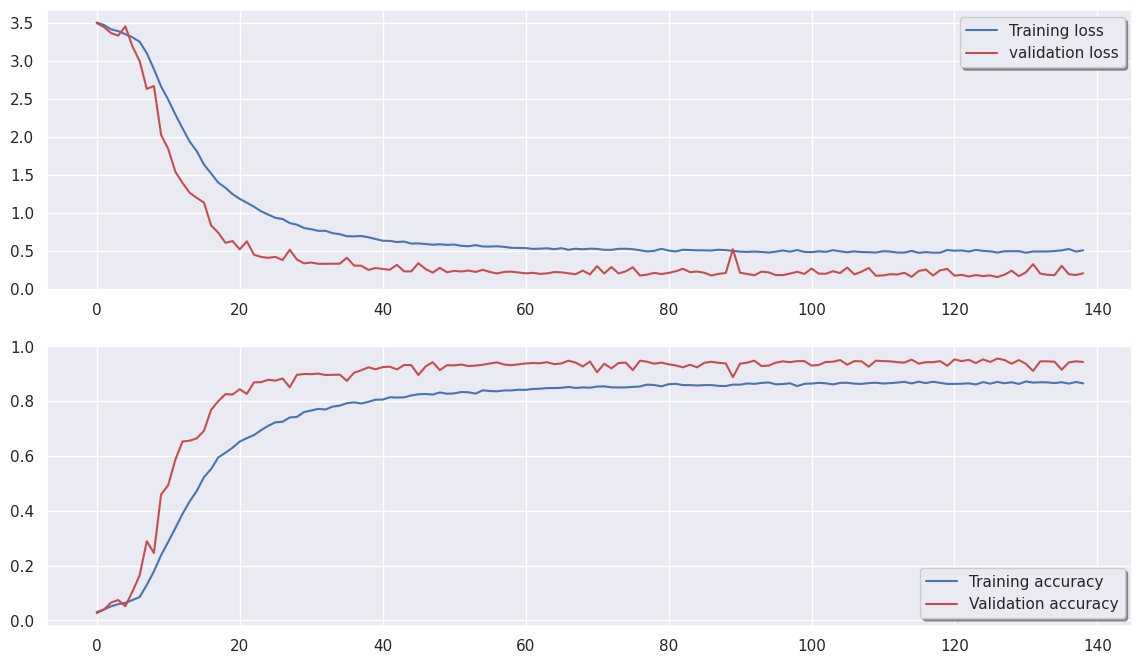

In [96]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [97]:
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Test: 0.958


45/45 [==============================] - 3s 58ms/step


<Axes: >

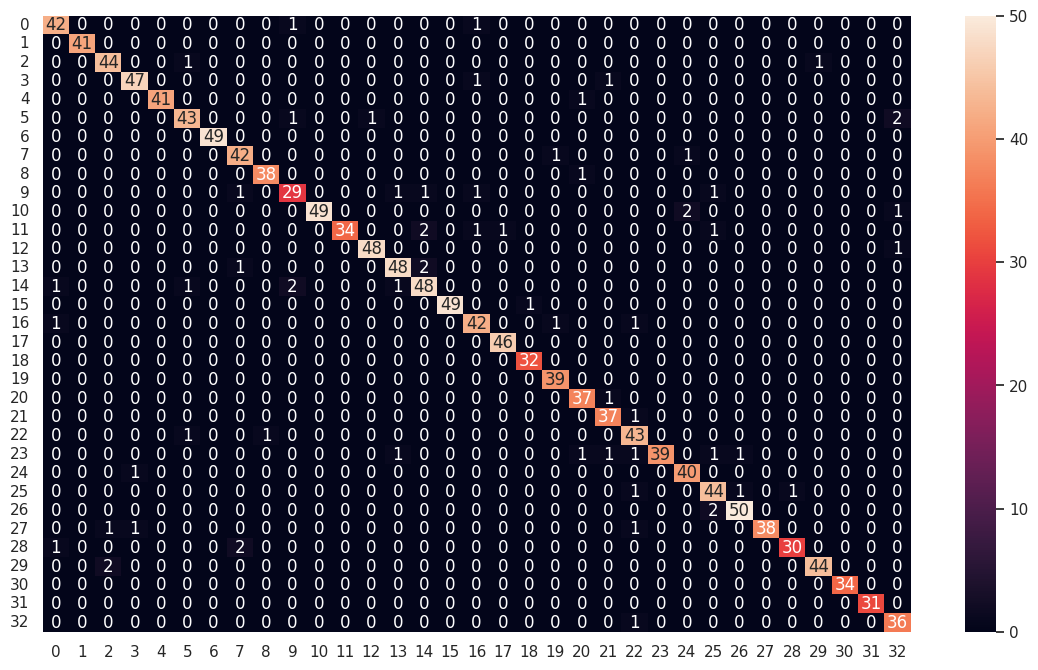

In [98]:
y_pred = deep_RU_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d')

45/45 [==============================] - 3s 58ms/step


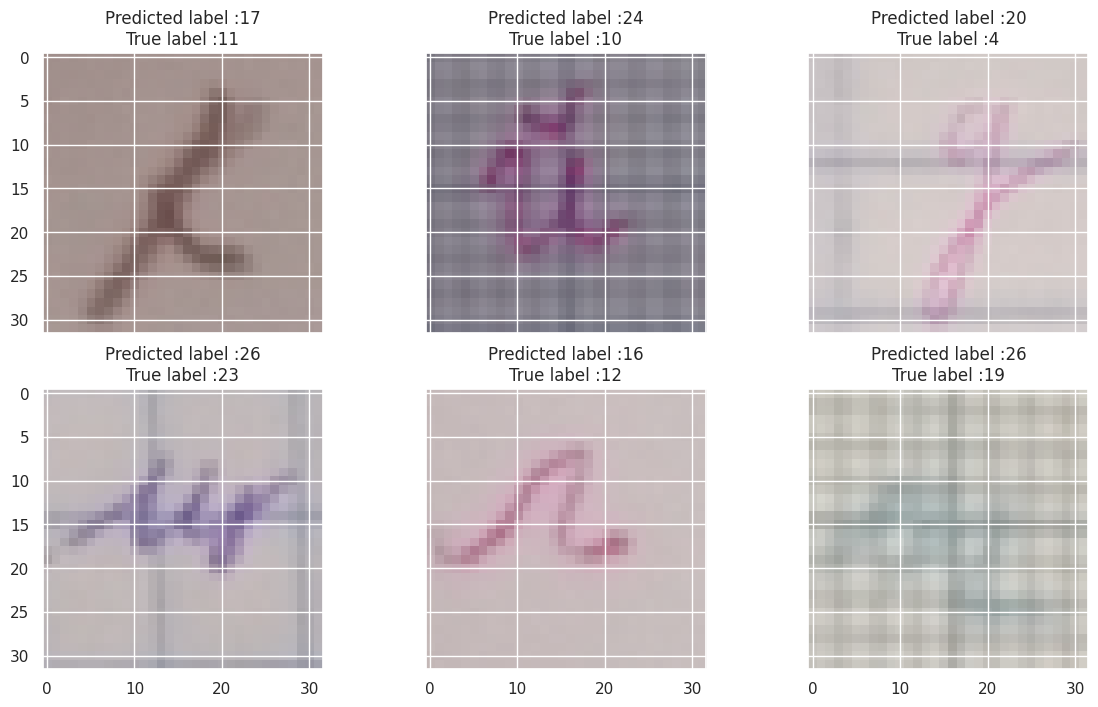

In [99]:
# Display some error results

# Convert one-hot vector to labels
Y_true = y_test

# Predict the values from the test dataset
Y_pred = saved_model.predict(X_test)
# Convert predictions from one-hot vectors to labels
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrongly predicted letters
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)